# filter2D

### 01.输入数据预处理
首先，导入src和dst文件，并将其处理为矩阵形式，并输出对应的图像

In [21]:
import numpy as np
with open("./src.txt", "r") as f:
    src = list(map(int, f.readlines()))
with open("./dst.txt", "r") as f:
    dst = list(map(int, f.readlines()))
img_in = np.array(src,np.uint8).reshape(128,128)
img_out = np.array(dst).reshape(126,126)
img_in,img_out

(array([[205, 204, 205, ..., 247, 247, 246],
        [205, 205, 204, ..., 248, 248, 248],
        [205, 205, 205, ..., 248, 247, 247],
        ...,
        [161, 164, 151, ..., 102, 102, 109],
        [174, 168, 173, ..., 119, 139,  93],
        [161, 156, 168, ..., 114, 119, 134]], dtype=uint8),
 array([[  2,   2,  -2, ...,   1,   2,   2],
        [  0,   0,   1, ...,   0,   0,  -1],
        [ -3,  -4,   0, ...,   0,   2,   1],
        ...,
        [ -1,  34,  59, ..., -28, -33,  -4],
        [ 39,  62,  59, ...,  32,  18,  24],
        [ 18, -16, -29, ..., -10, -35, -23]]))

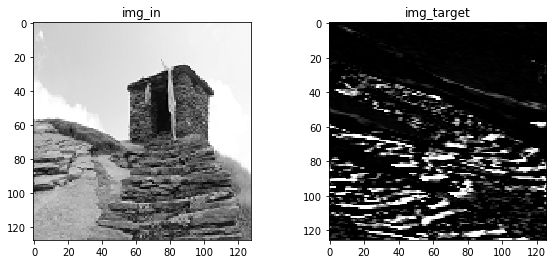

In [22]:
from matplotlib import pyplot as plt
fig_filter2D = plt.figure()
fig_filter2D.set_figheight(4)
fig_filter2D.set_figwidth(15)
fig_1 = fig_filter2D.add_subplot(131)
fig_1.title.set_text('img_in')
plt.imshow(img_in,cmap='gray')
fig_1 = fig_filter2D.add_subplot(132)
fig_1.title.set_text('img_target')
plt.imshow(np.clip(img_out, 0, 255),cmap='gray')

根据图像的显示分析，这里对所提供的test文件中的数据可能并不是特别好的数据

## 02.输入filter2D所需的卷积核

In [23]:
kernel = np.array([-1,-2,-1,0,0,0,1,2,1])
kernel = kernel.reshape(3,3)

## 03.使用cv中的filter2d函数

In [37]:
import cv2 as cv
import time
img_in = np.array(img_in,np.uint8)
start_time = time.time()
dst = cv.filter2D(img_in,cv.CV_8U,kernel)
end_time = time.time()
print("耗时：{}s".format(end_time - start_time))

耗时：0.0028154850006103516s


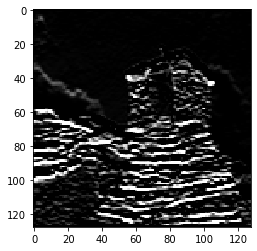

In [38]:
fig_out = plt.figure()
fig_out.set_figheight(4)
fig_out.set_figwidth(15)
fig_out.add_subplot(131)
plt.imshow(dst, cmap='gray')

## 04.载入Overlay

In [39]:
from pynq import Overlay,allocate
overlay = Overlay("../overlay/filter2D.bit")
filter2d = overlay.filter2d_accel_0
#overlay.hierarchy_dict

## 05.分配内存供IP使用


In [40]:
rows,cols = img_in.shape
input_buffer = allocate(shape=(128*128,),dtype='i4')
output_buffer = allocate(shape=(126*126,),dtype='i4')
kernel_buffer = allocate(shape=(3*3,),dtype='i4')
#将数据输入到分配的内存中
np.copyto(input_buffer,np.int16(src))
np.copyto(kernel_buffer,np.int16([-1, -2, -1, 
                                   0,  0,  0, 
                                   1,  2,  1]))

测试参数写入情况

In [41]:
rows,cols

(128, 128)

In [42]:
input_buffer,kernel_buffer

(PynqBuffer([205, 204, 205, ..., 114, 119, 134]),
 PynqBuffer([-1, -2, -1,  0,  0,  0,  1,  2,  1]))

## 06.配置IP

In [43]:
filter2d.s_axi_control.write(0x10,input_buffer.physical_address)
filter2d.s_axi_control.write(0x28,output_buffer.physical_address)
filter2d.s_axi_CTRL.write(0x10,rows)
filter2d.s_axi_CTRL.write(0x18,cols)
filter2d.s_axi_control.write(0x1c,kernel_buffer.physical_address)

## 07.启动IP

In [44]:
import time
filter2d.s_axi_CTRL.write(0x00, 0x01)
start_time = time.time()
while True:
    reg = filter2d.s_axi_CTRL.read(0x00)
    if reg != 1:
        break
end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：0.018537282943725586s


这里正确的结果应该被写入`output_buffer`中，但是尚未成功。
这里的HLS设计通过了C simulation，C synthesis以及Cosimulation，尚未找到出错点。

In [45]:
output = np.int16(output_buffer)
output

PynqBuffer([-1843, -3684, -1850, ...,     0,     0,     0], dtype=int16)

## 结果可视化

打印output_buffer代表的图像

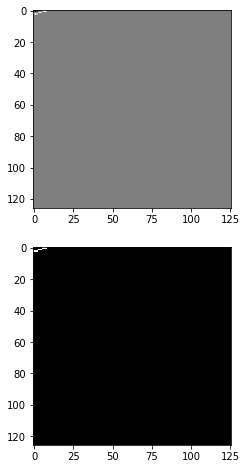

In [16]:
fig_img_out = plt.figure()
fig_img_out.set_figheight(8)
fig_img_out.set_figwidth(15)
fig_img_out.add_subplot(231)
plt.imshow(output.reshape(126, 126), cmap='gray')
fig_img_out.add_subplot(234)
plt.imshow(np.clip(output.reshape(126, 126), 0, 255), cmap='gray')
